In [1]:
from plugins.calibration.sn_calibration_baseline.camera import Camera
import cv2
from matplotlib import pyplot as plt
from copy import deepcopy
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import json
import os
import numpy as np

# plt.rcParams['figure.figsize'] = [15, 15]

In [2]:
camParamsPath = "Labels-GameState360.json"
imgPath = 'Images/360/'
maskPath = 'out360/tta/'
imgNum = 500

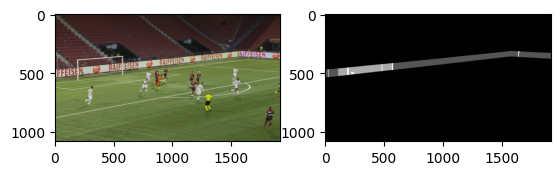

In [3]:
with open(camParamsPath, "r") as f:
	camParams = json.load(f)["annotations"]
camParams = [x["parameters"] for x in camParams if x["supercategory"] == "camera"]
cam = Camera()
cam.from_json_parameters(camParams[imgNum - 1])  # camParams is 0-indexed whereas img_num is 1-indexed
img = cv2.imread(imgPath + str(imgNum).zfill(6) + '.jpg')
mask = cv2.imread(maskPath + str(imgNum).zfill(6) + '.png', cv2.IMREAD_GRAYSCALE)
# plot img and mask side by side
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.show()

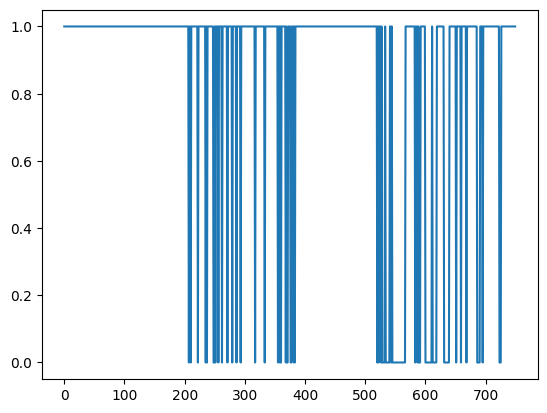

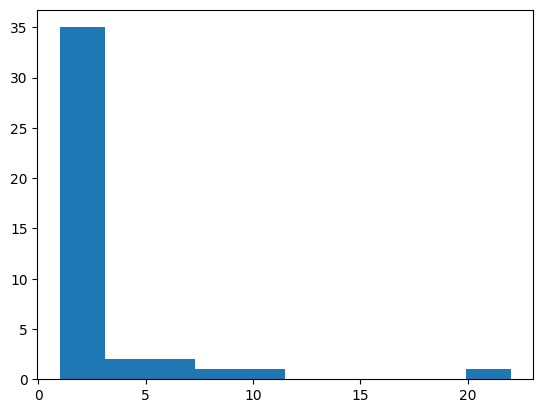

In [4]:
completeParams = np.zeros(len(camParams), dtype=np.bool_)
distOfNonCompleteParams = []
currDist = 0
for i, params in enumerate(camParams):
	if type(params) is dict:
		completeParams[i] = True
		if currDist > 0:
			distOfNonCompleteParams.append(currDist)
			currDist = 0
	else:
		completeParams[i] = False
		currDist += 1

plt.plot(completeParams)
plt.show()
plt.hist(distOfNonCompleteParams)
plt.show()

In [5]:
np.sort(distOfNonCompleteParams)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  3,
        3,  5,  5,  7,  7,  9, 11, 22])

In [6]:
sum(distOfNonCompleteParams)

108

In [7]:
camParams2 = deepcopy(camParams)
positionOf1distNonCompleteParams = []
for i in range(len(camParams2)):
	if not completeParams[i]:
		if i == 0:
			continue
		elif i == len(camParams2) - 1:
			continue
		else:
			if completeParams[i - 1] and completeParams[i + 1]:
				camParams2[i] = camParams2[i - 1]
				positionOf1distNonCompleteParams.append(i)

In [8]:
len(positionOf1distNonCompleteParams)

30

In [9]:
print(positionOf1distNonCompleteParams)

[207, 210, 222, 235, 237, 251, 256, 262, 271, 279, 286, 293, 317, 333, 355, 358, 360, 368, 381, 383, 520, 522, 526, 543, 583, 587, 651, 659, 668, 695]


In [10]:
for i in range(len(camParams)):
    if type(camParams[i]) == type(None):
        camParams[i] = camParams[i - 1]
    elif type(camParams[i]) == list:
        cam.from_json_parameters(camParams[i - 1])  # the homography won't give info about some camera parameters such as the distortions, so we take the previous camera parameters as a starting point
        cam.from_homography(camParams[i])
        camParams[i] = cam.to_json_parameters()
        
for i in range(len(camParams2)):
    if type(camParams2[i]) == type(None):
        camParams2[i] = camParams2[i - 1]
    elif type(camParams2[i]) == list:
        cam.from_json_parameters(camParams2[i - 1])  # the homography won't give info about some camera parameters such as the distortions, so we take the previous camera parameters as a starting point
        cam.from_homography(camParams2[i])
        camParams2[i] = cam.to_json_parameters()

In [14]:
panDegrees = [x["pan_degrees"] for x in camParams if type(x) == dict]
panDegrees2 = [x["pan_degrees"] for x in camParams2 if type(x) == dict]
np.array(panDegrees2)[positionOf1distNonCompleteParams]

array([-38.03694074, -37.16449536, -36.35852472, -35.8988329 ,
       -35.97724301, -35.36005573, -35.21150337, -35.12515454,
       -35.3182314 , -34.73648747, -34.15077158, -33.62497252,
       -30.49715946, -28.64679518, -28.24506541, -28.45916687,
       -28.92589259, -31.75476736, -37.43800343, -38.71262121,
       -31.86187131, -29.92979557, -26.39225191,  -9.40760193,
        13.87992075,  15.20977594,  35.05251244,  36.22845954,
        36.89855824,  38.35286885])

750 750


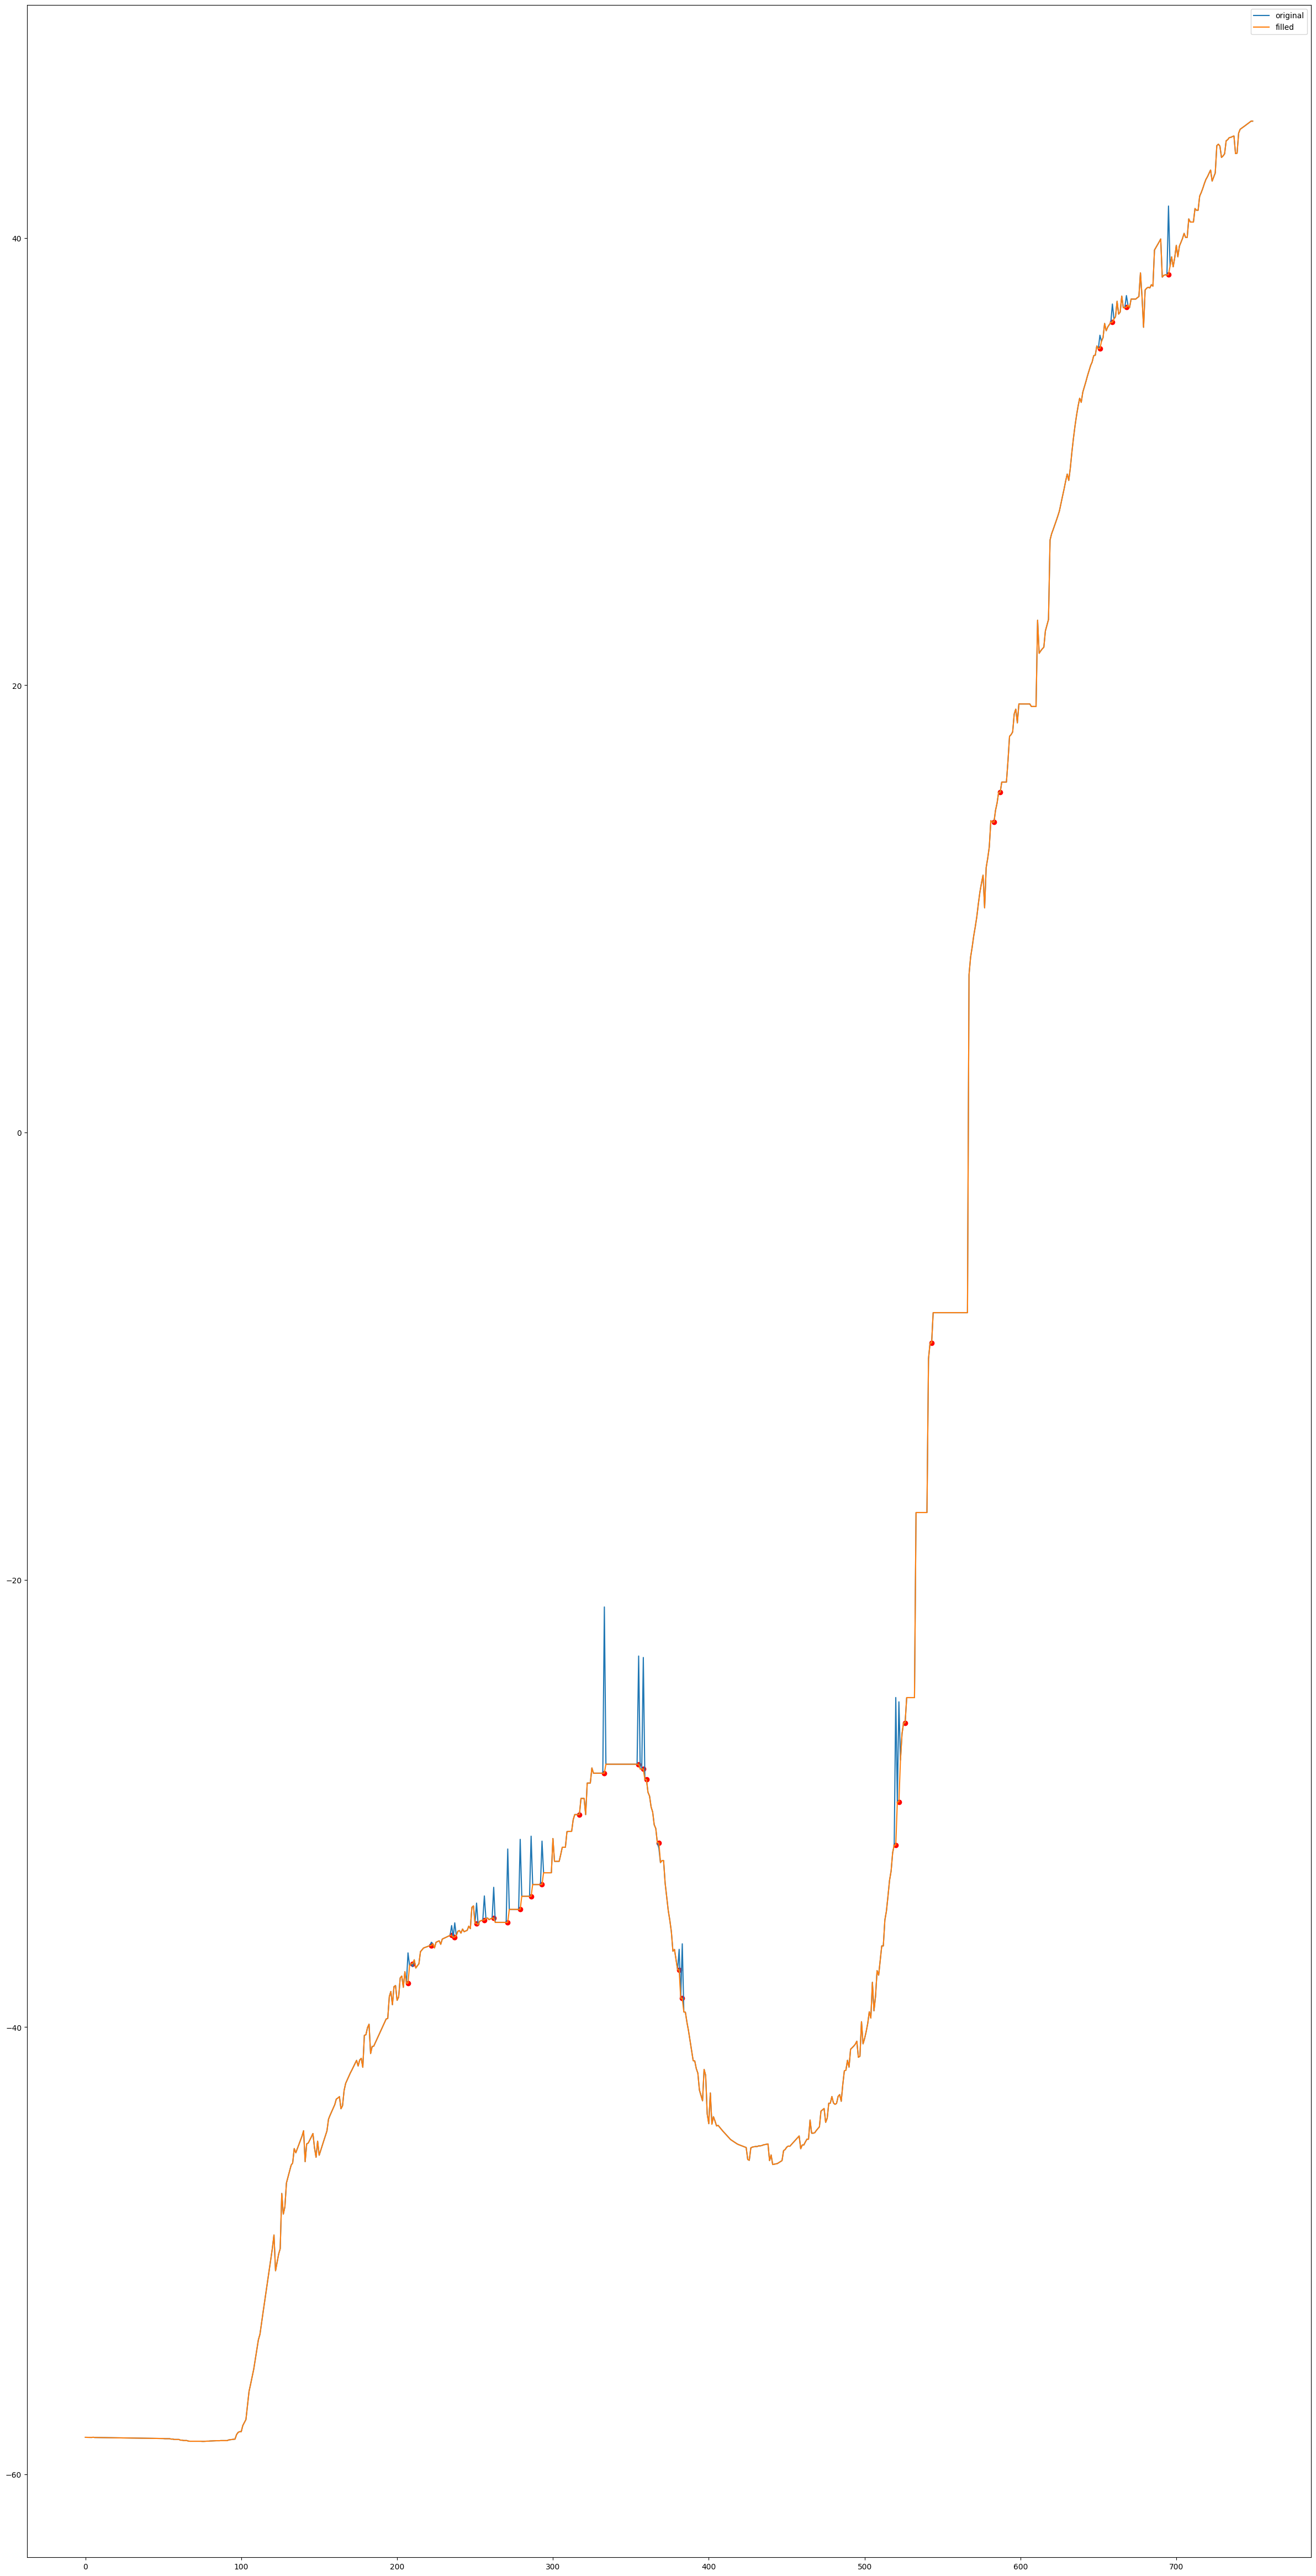

In [19]:
print(len(panDegrees), len(panDegrees2))
# plot pan degrees
plt.figure(figsize=(30, 60))
plt.plot(panDegrees)
plt.plot(panDegrees2)
# plot points with x=positionOf1distNonCompleteParams and y=np.array(panDegrees2)[positionOf1distNonCompleteParams]
plt.scatter(positionOf1distNonCompleteParams, np.array(panDegrees2)[positionOf1distNonCompleteParams], color='red')
plt.legend(["original", "filled"])
plt.show()

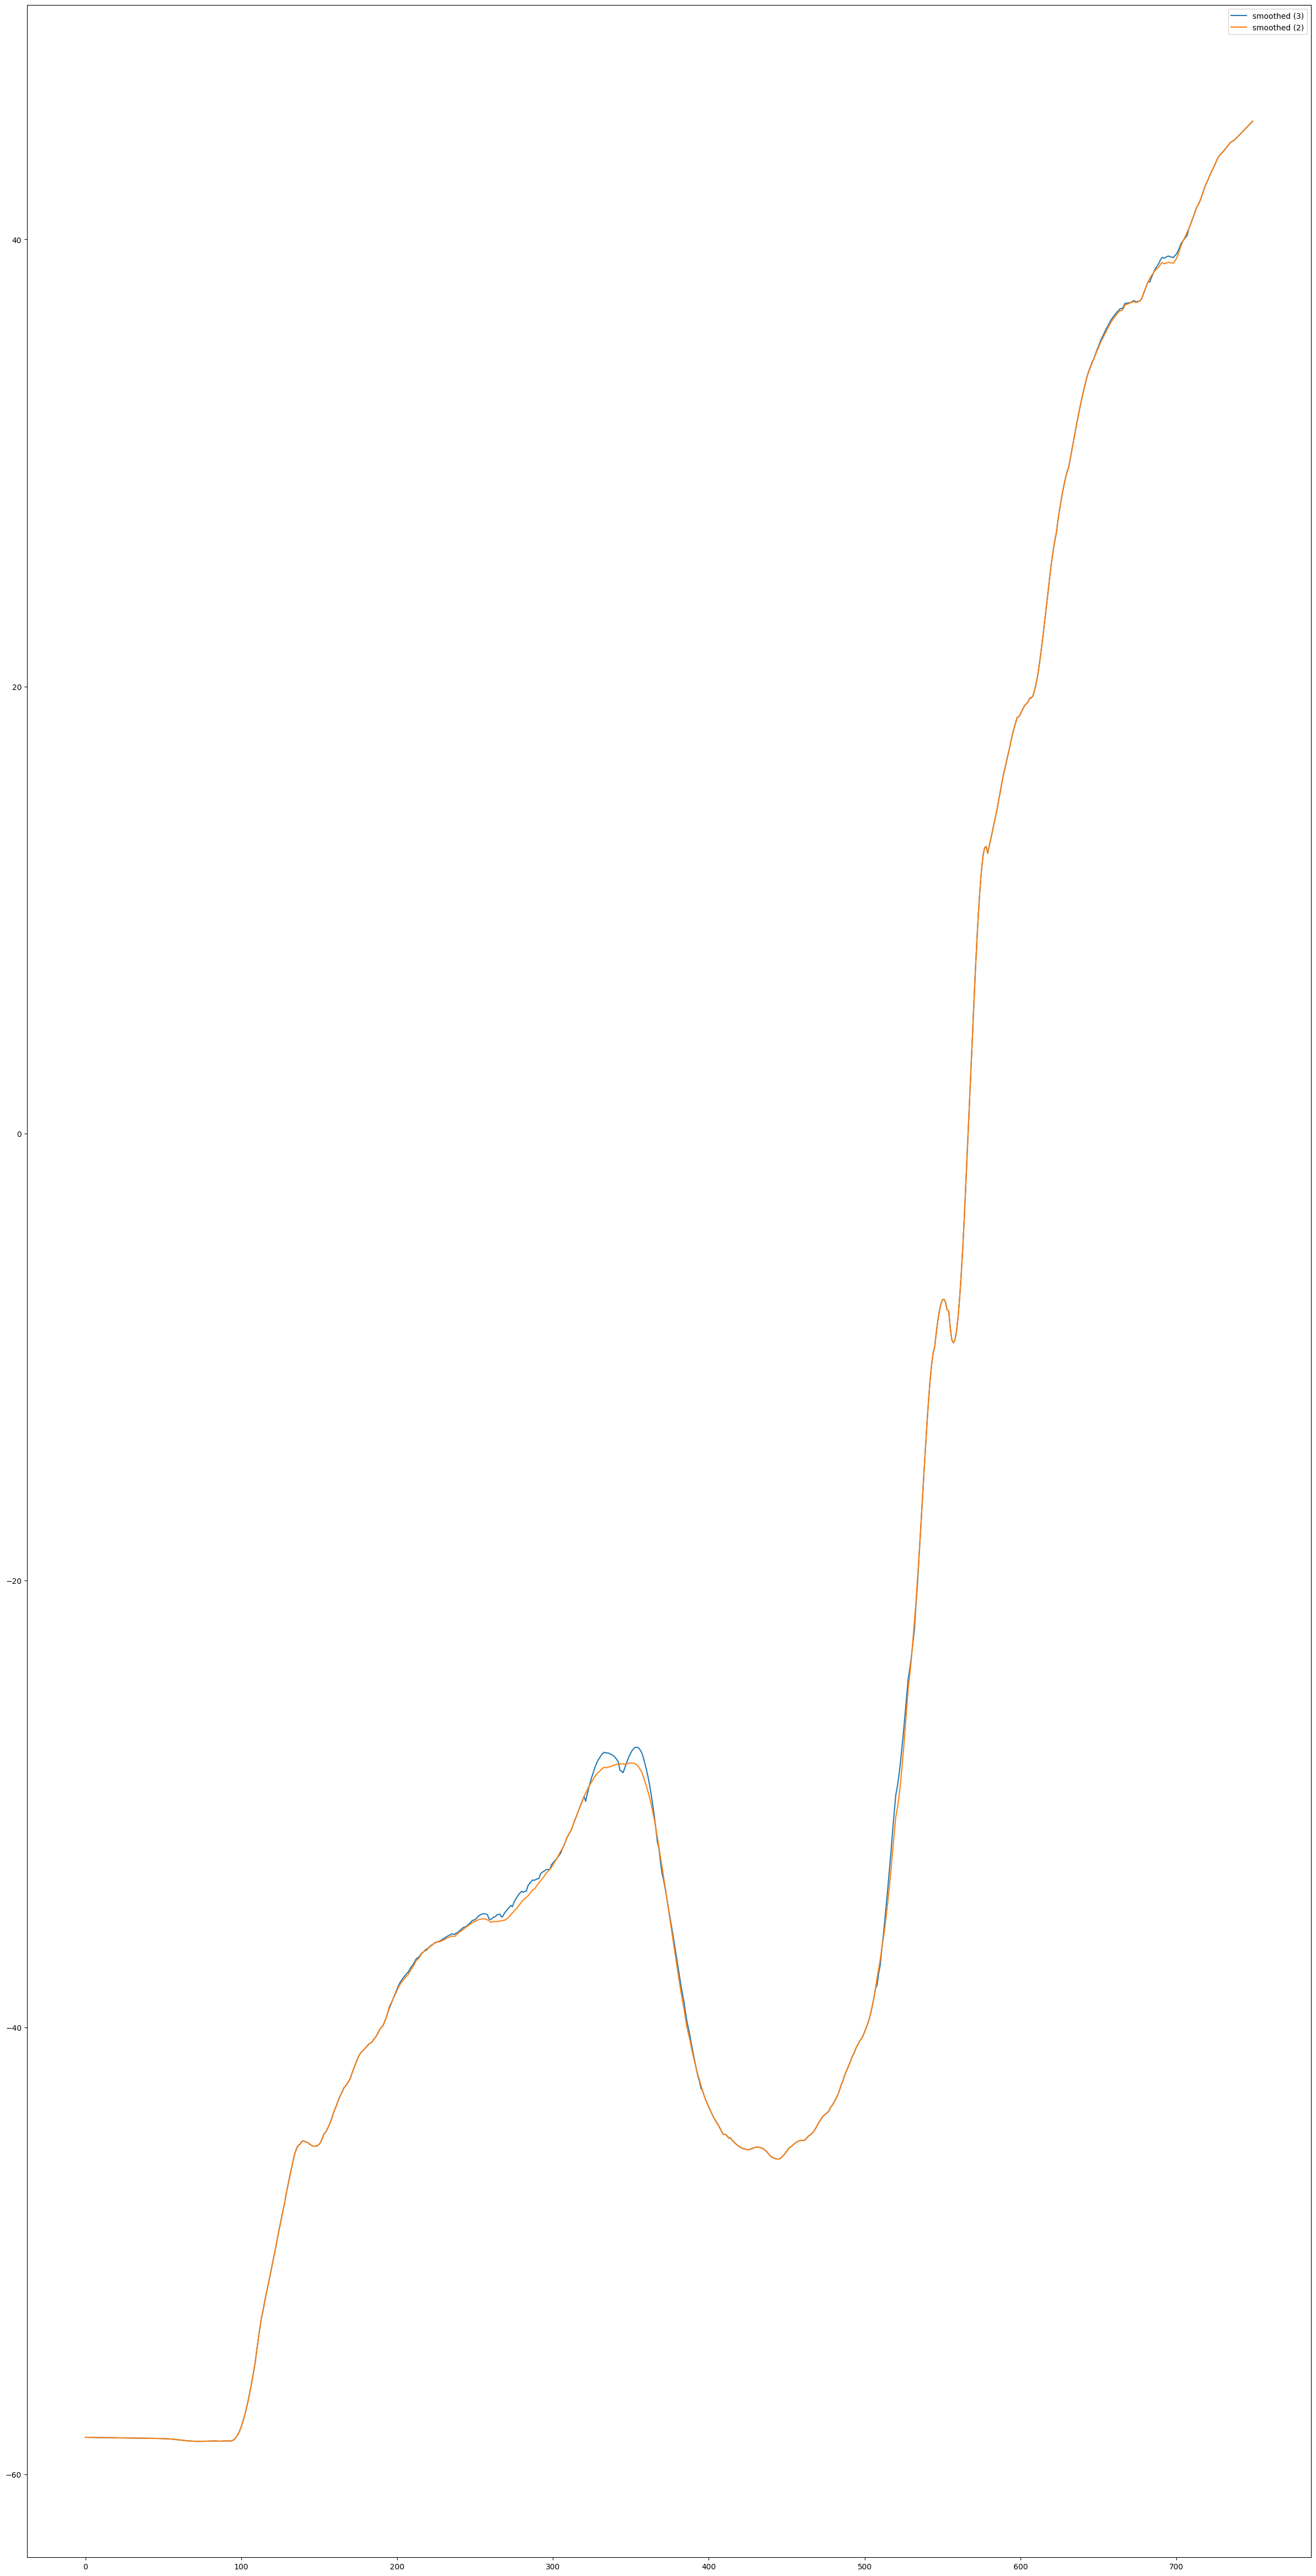

In [20]:
import scipy.signal

# smooth pan degrees
panDegreesSmooth3 = scipy.signal.savgol_filter(panDegrees, 25, 2)
panDegreesSmooth2 = scipy.signal.savgol_filter(panDegrees2, 25, 2)
# plot both on same graph
# plt.plot(panDegrees, label='original')
plt.figure(figsize=(30, 60))
plt.plot(panDegreesSmooth3, label='smoothed (3)')
plt.plot(panDegreesSmooth2, label='smoothed (2)')
plt.legend()
plt.show()

In [7]:
indCamParams = {
    "pan_degrees": [x["pan_degrees"] for x in camParams],
    "tilt_degrees": [x["tilt_degrees"] for x in camParams],
    "roll_degrees": [x["roll_degrees"] for x in camParams],
    "position_meters": [x["position_meters"] for x in camParams],
    "x_focal_length": [x["x_focal_length"] for x in camParams],
    "y_focal_length": [x["y_focal_length"] for x in camParams],
    "principal_point": [x["principal_point"] for x in camParams],
    "radial_distortion": [x["radial_distortion"] for x in camParams],
    "tangential_distortion": [x["tangential_distortion"] for x in camParams],
    "thin_prism_distortion": [x["thin_prism_distortion"] for x in camParams]
}

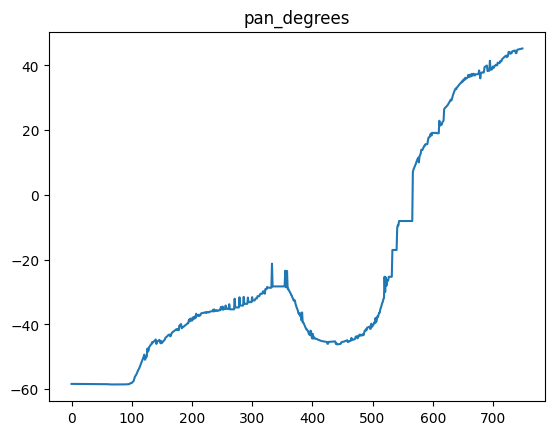

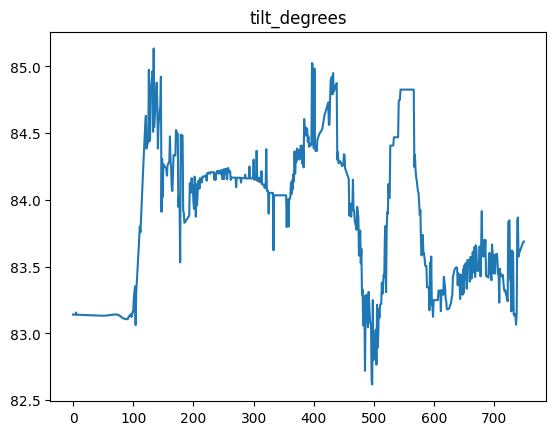

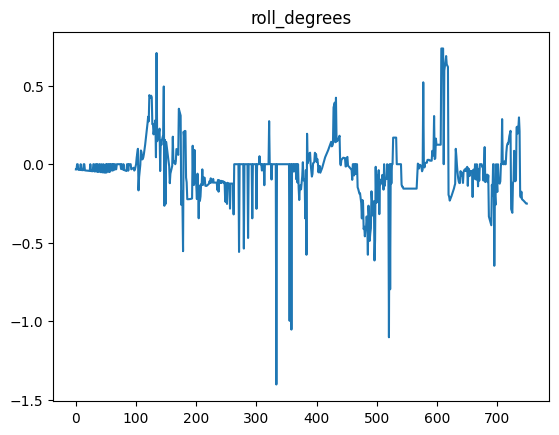

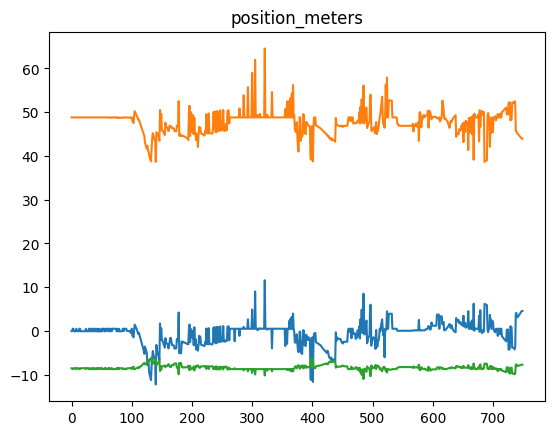

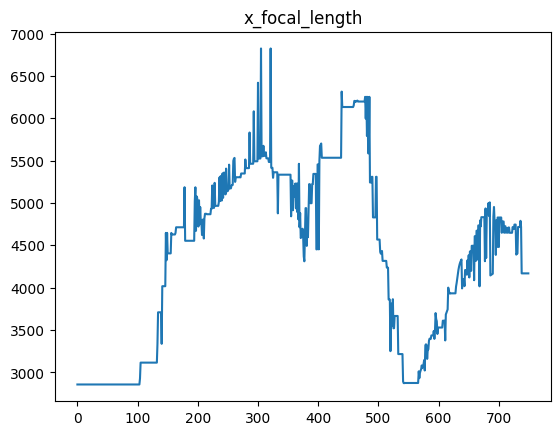

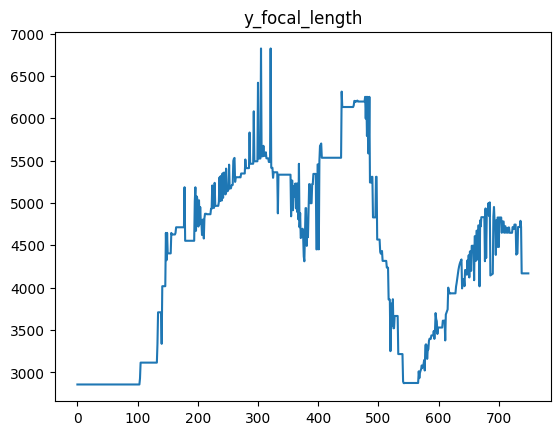

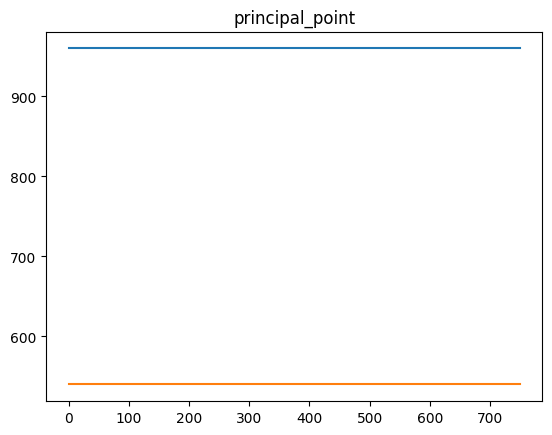

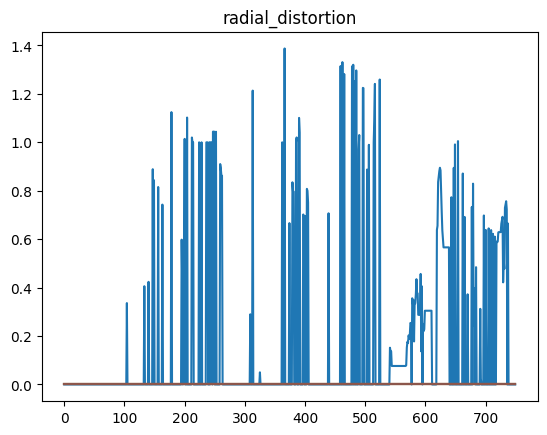

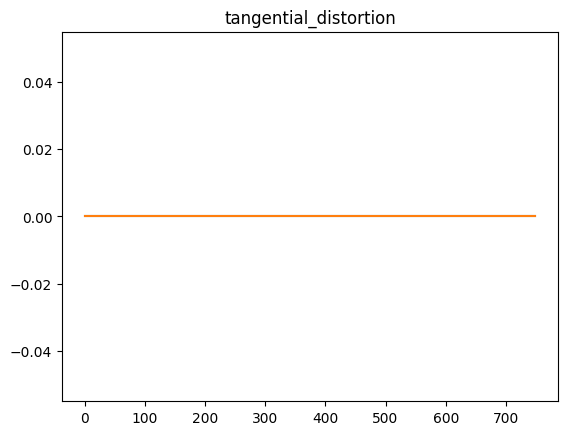

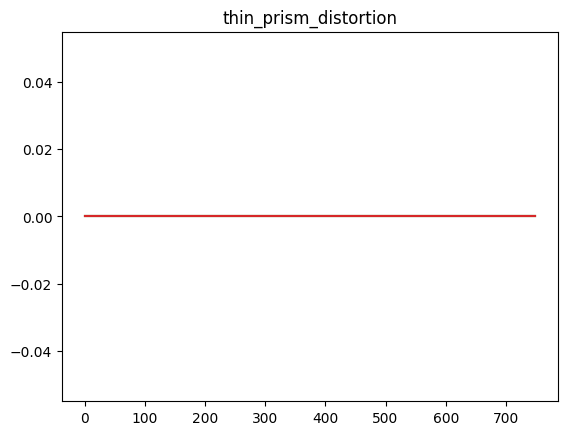

In [8]:
# plot each key in indCamParams in a subplot
for key in indCamParams.keys():
    plt.plot(indCamParams[key])
    plt.title(key)
    plt.show()

In [9]:
lngth = len(camParams)
smoothedIndCamParams = deepcopy(indCamParams)
for key in indCamParams.keys():
    smoothedIndCamParams[key] = scipy.signal.savgol_filter(indCamParams[key], 25, 3, axis=0)

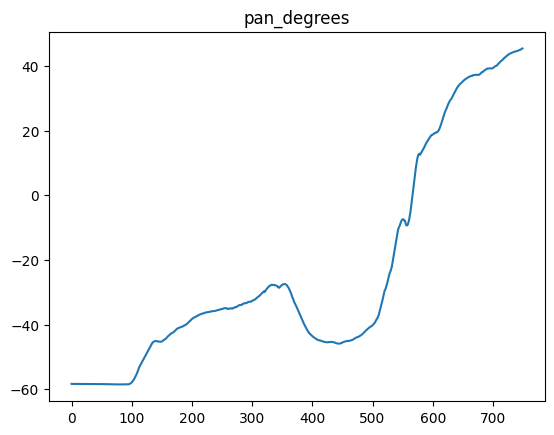

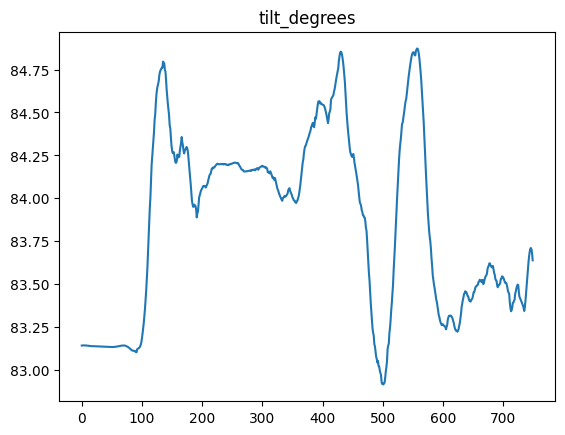

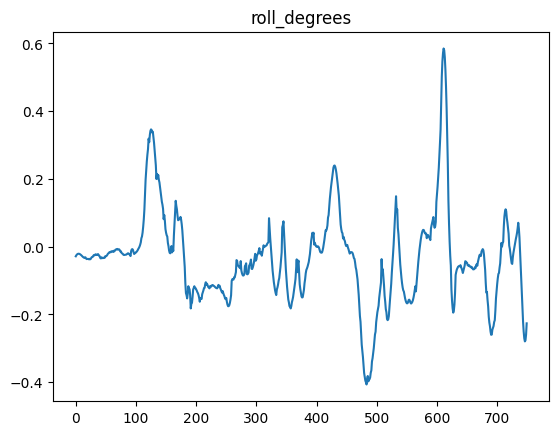

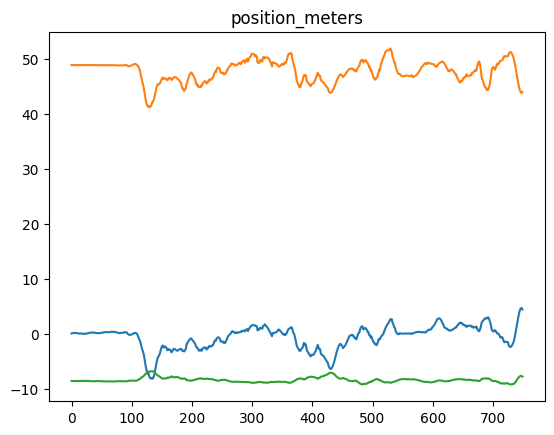

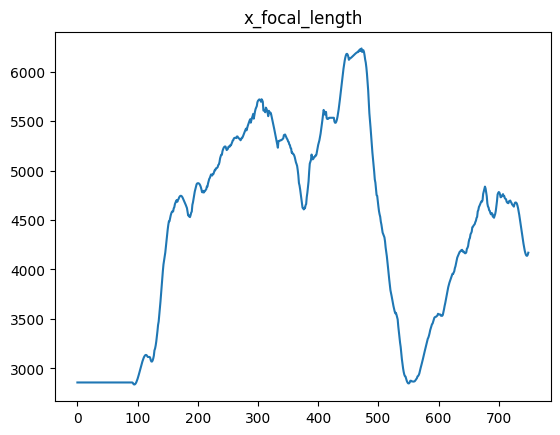

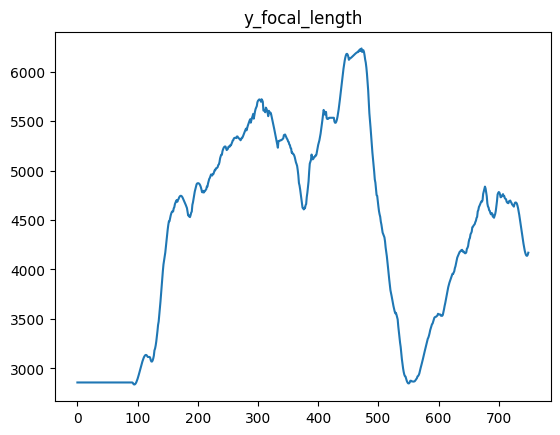

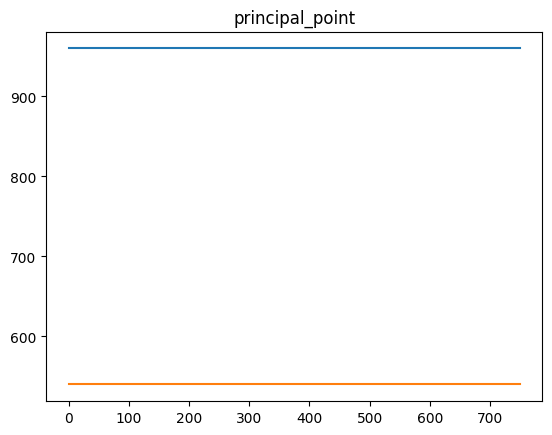

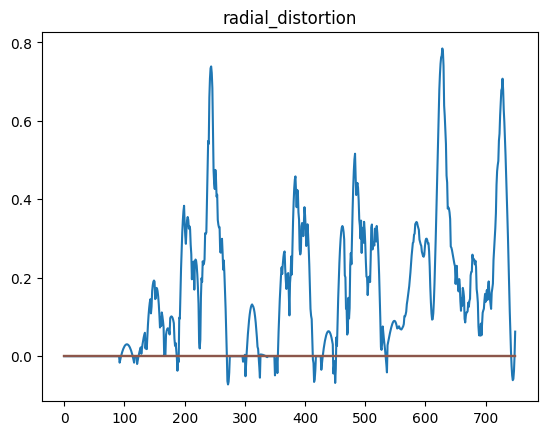

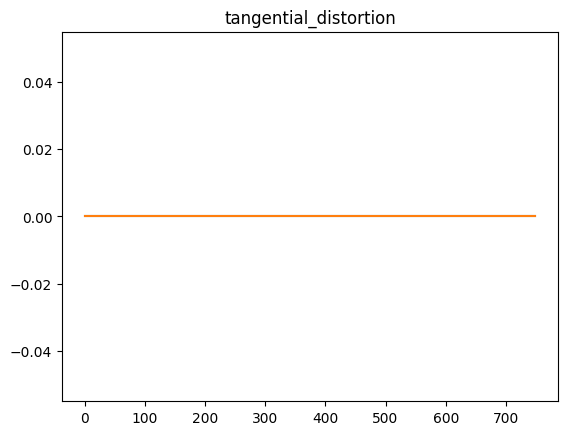

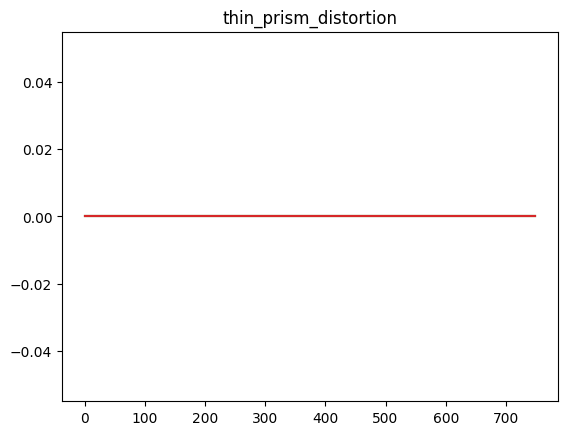

In [10]:
for key in smoothedIndCamParams.keys():
    plt.plot(smoothedIndCamParams[key])
    plt.title(key)
    plt.show()

In [11]:
smoothedCamParams = [dict(zip(smoothedIndCamParams.keys(), [smoothedIndCamParams[key][i] for key in smoothedIndCamParams.keys()])) for i in range(lngth)]

In [12]:
# change ndarray in the dict to list
for i in range(lngth):
    smoothedCamParams[i]["position_meters"] = smoothedCamParams[i]["position_meters"].tolist()
    smoothedCamParams[i]["principal_point"] = smoothedCamParams[i]["principal_point"].tolist()
    smoothedCamParams[i]["radial_distortion"] = np.abs(smoothedCamParams[i]["radial_distortion"]).tolist()
    smoothedCamParams[i]["tangential_distortion"] = np.abs(smoothedCamParams[i]["tangential_distortion"]).tolist()
    smoothedCamParams[i]["thin_prism_distortion"] = np.abs(smoothedCamParams[i]["thin_prism_distortion"]).tolist()

In [13]:
mask_path = "out360/tta/"
path = 'Images/360'
imgs = os.listdir(path)
imgs.sort()
len(imgs)

750

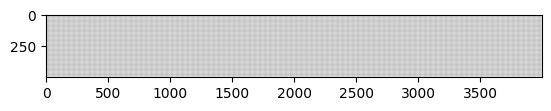

In [14]:
# Create a 1080x1920 grid image with white background, black lines and squares of 5x5 pixels
squareSize = 10
gridWidth = 4000
gridHeight = 500
grid = np.zeros((gridHeight, gridWidth, 3), dtype=np.uint8)
grid.fill(255)
for i in range(0, gridWidth, squareSize):
	cv2.line(grid, (i, 0), (i, gridHeight), (0, 0, 0), 1)
for i in range(0, gridHeight, squareSize):
	cv2.line(grid, (0, i), (gridWidth, i), (0, 0, 0), 1)
# plot grid
plt.imshow(grid)
# save image with a dpi of 300
# plt.imsave('grid.png', grid, dpi=300)

In [15]:
srcPoints = np.float32([[gridWidth//2, gridHeight-1], [gridWidth//2, gridHeight-1 - 3*squareSize], [gridWidth//2 + 3*squareSize, gridHeight-1 - 3*squareSize], [gridWidth//2 + 3*squareSize, gridHeight-1]])
worldDstPoints = np.float64([[0,-34,0], [0,-34,-1], [1,-34, -1], [1,-34,0]])
camParamsTypesDict = {
    type(None): -1,
    list: 0,
    dict: 1,
}
xLength = 25*1

In [16]:
def superimposeImage(imageName, iteration):
	img = cv2.imread(path + '/' + imageName)
	mask = cv2.imread(mask_path + imageName[:-4] + '.png', cv2.IMREAD_GRAYSCALE)  # type: ignore
	mask = np.bitwise_and(mask > 0, mask < 3)
	cam.from_json_parameters(smoothedCamParams[iteration])
	dstPoints = np.float32([cam.project_point(pt, distort=False)[:2] for pt in worldDstPoints])
	M = cv2.getPerspectiveTransform(srcPoints, dstPoints)
	warpedGrid = cv2.warpPerspective(grid, M, (img.shape[1], img.shape[0]))
	img[mask] = warpedGrid[mask]
	cam.draw_corners(cam.draw_pitch(img))
	# if iteration >=  xLength - 1:
	# 	x = [i for i in range(iteration-xLength+1, iteration+1)]
	# 	y = [camParamsTypesDict[type(camJsonParams[i]["parameters"])] for i in range(iteration-xLength+1, iteration+1)]
	# 	# plot the data and put the plot in the image
	# 	plt.plot(x, y)
	# 	plt.ylim(-1.5, 1.5)
	# 	plt.savefig('plot.png')
	# 	plot = cv2.imread('plot.png')
	# 	# put the plot in the lower left corner of the image
	# 	img[img.shape[0]-plot.shape[0]:, :plot.shape[1]] = plot
	# 	plt.clf()
	return img

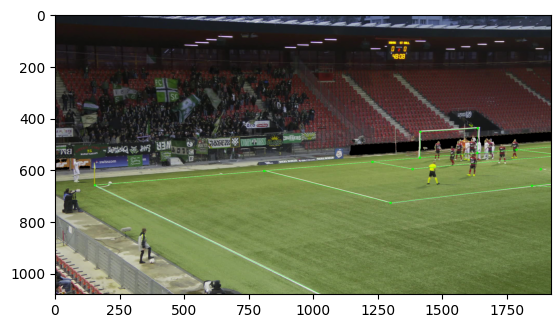

In [17]:
it=0
test = superimposeImage(imgs[it], it)
# change from BGR to RGB
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
plt.imshow(test)

In [18]:
# Get the first image
img = cv2.imread(path + '/' + imgs[0])
height, width, layers = img.shape
print(height, width, layers)

# Create a video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  #type: ignore
video = cv2.VideoWriter('video_mask_smoothed.mp4', fourcc, 25, (width,height))

# Write all images to the video
for i in tqdm(range(len(imgs))):
	img = superimposeImage(imgs[i], i)
	video.write(img)

# Close the video writer
video.release()

1080 1920 3


 24%|██▍       | 179/750 [00:17<00:56, 10.15it/s]


KeyboardInterrupt: 